# Heart Disease Risk Prediction

## Introduction

Main goals of the project:
- explore the data and identify key factors that influence heart attack risk;
- perform preprocessing and detect target leakage;
- build and compare several models (sklearn, CatBoost);
- choose the optimal quality metric and explain the choice;
- prepare a reproducible ML pipeline with the ability to perform inference on new data.

## Final solution format

As a result, the project should include:
- a Jupyter Notebook with EDA, data analysis, and model training results;
- a library (Python modules) containing classes for data processing and inference;
- a FastAPI web application that accepts data and returns predictions;
- model artifacts in `joblib` format (for sklearn) and `cbm` (for CatBoost) with a meta file `artifacts/best_meta.json` for loading;
- predictions on the test set in `.csv` format with columns `id` and `prediction`;
- documentation with instructions for running the application.

## Tech stack

- Python (OOP, modular architecture)
- Pandas, NumPy
- scikit-learn
- CatBoost
- FastAPI
- HTML

## Metrics

Since the task deals with medical diagnostics, the emphasis is on **Recall/Sensitivity**: it is important to minimize the number of missed high-risk patients. Precision, F-score, and ROC-AUC were also considered for a comprehensive evaluation.

---

Next steps in the notebook:
1. Familiarization with the data (EDA).
2. Preprocessing (type casting, handling missing values, processing correlations and leakage).
3. Model training and hyperparameter tuning.
4. Metric selection and justification.
5. Preparing artifacts for inference.

---

In [1]:
# ==== Imports ====
import warnings
import uvicorn, nest_asyncio
from pathlib import Path
import pandas as pd
# ==== Local Modules ====
import sys, os
proj_root = os.path.abspath(".")
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)
from src.eda_analyzer import EDAAnalyzer
from src.quick_view import QuickView
from src.heart_runner import RunCfg
from src.heart_job import HeartRiskJob
from src.inference_utils import HeartRiskInference
from app.main import app, _choose_free_port
from src.inference_reporter import SimpleInferenceSummary

# ==== Settings ====
warnings.filterwarnings("ignore")


In [2]:
# === Path configuration ===
DATA_DIR = Path.cwd().parent / "data"

TRAIN_PATH = DATA_DIR / "heart_train.csv"
TEST_PATH = DATA_DIR / "heart_test.csv"
TARGET = "Heart Attack Risk (Binary)"

# === Data loading ===
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)


=== QUICK OVERVIEW ===

Appearance (head, T):
                                        0         1         2         3  \
Unnamed: 0                              0         1         2         3   
Age                              0.359551  0.202247  0.606742  0.730337   
Cholesterol                      0.732143     0.325  0.860714  0.007143   
Heart rate                       0.074244  0.047663  0.055912  0.053162   
Diabetes                              1.0       1.0       1.0       0.0   
Family History                        1.0       1.0       0.0       0.0   
Smoking                               1.0       0.0       1.0       1.0   
Obesity                               1.0       0.0       1.0       0.0   
Alcohol Consumption                   1.0       1.0       1.0       1.0   
Exercise Hours Per Week          0.535505   0.06869  0.944001  0.697023   
Diet                                    1         2         2         0   
Previous Heart Problems               1.0       1.0   

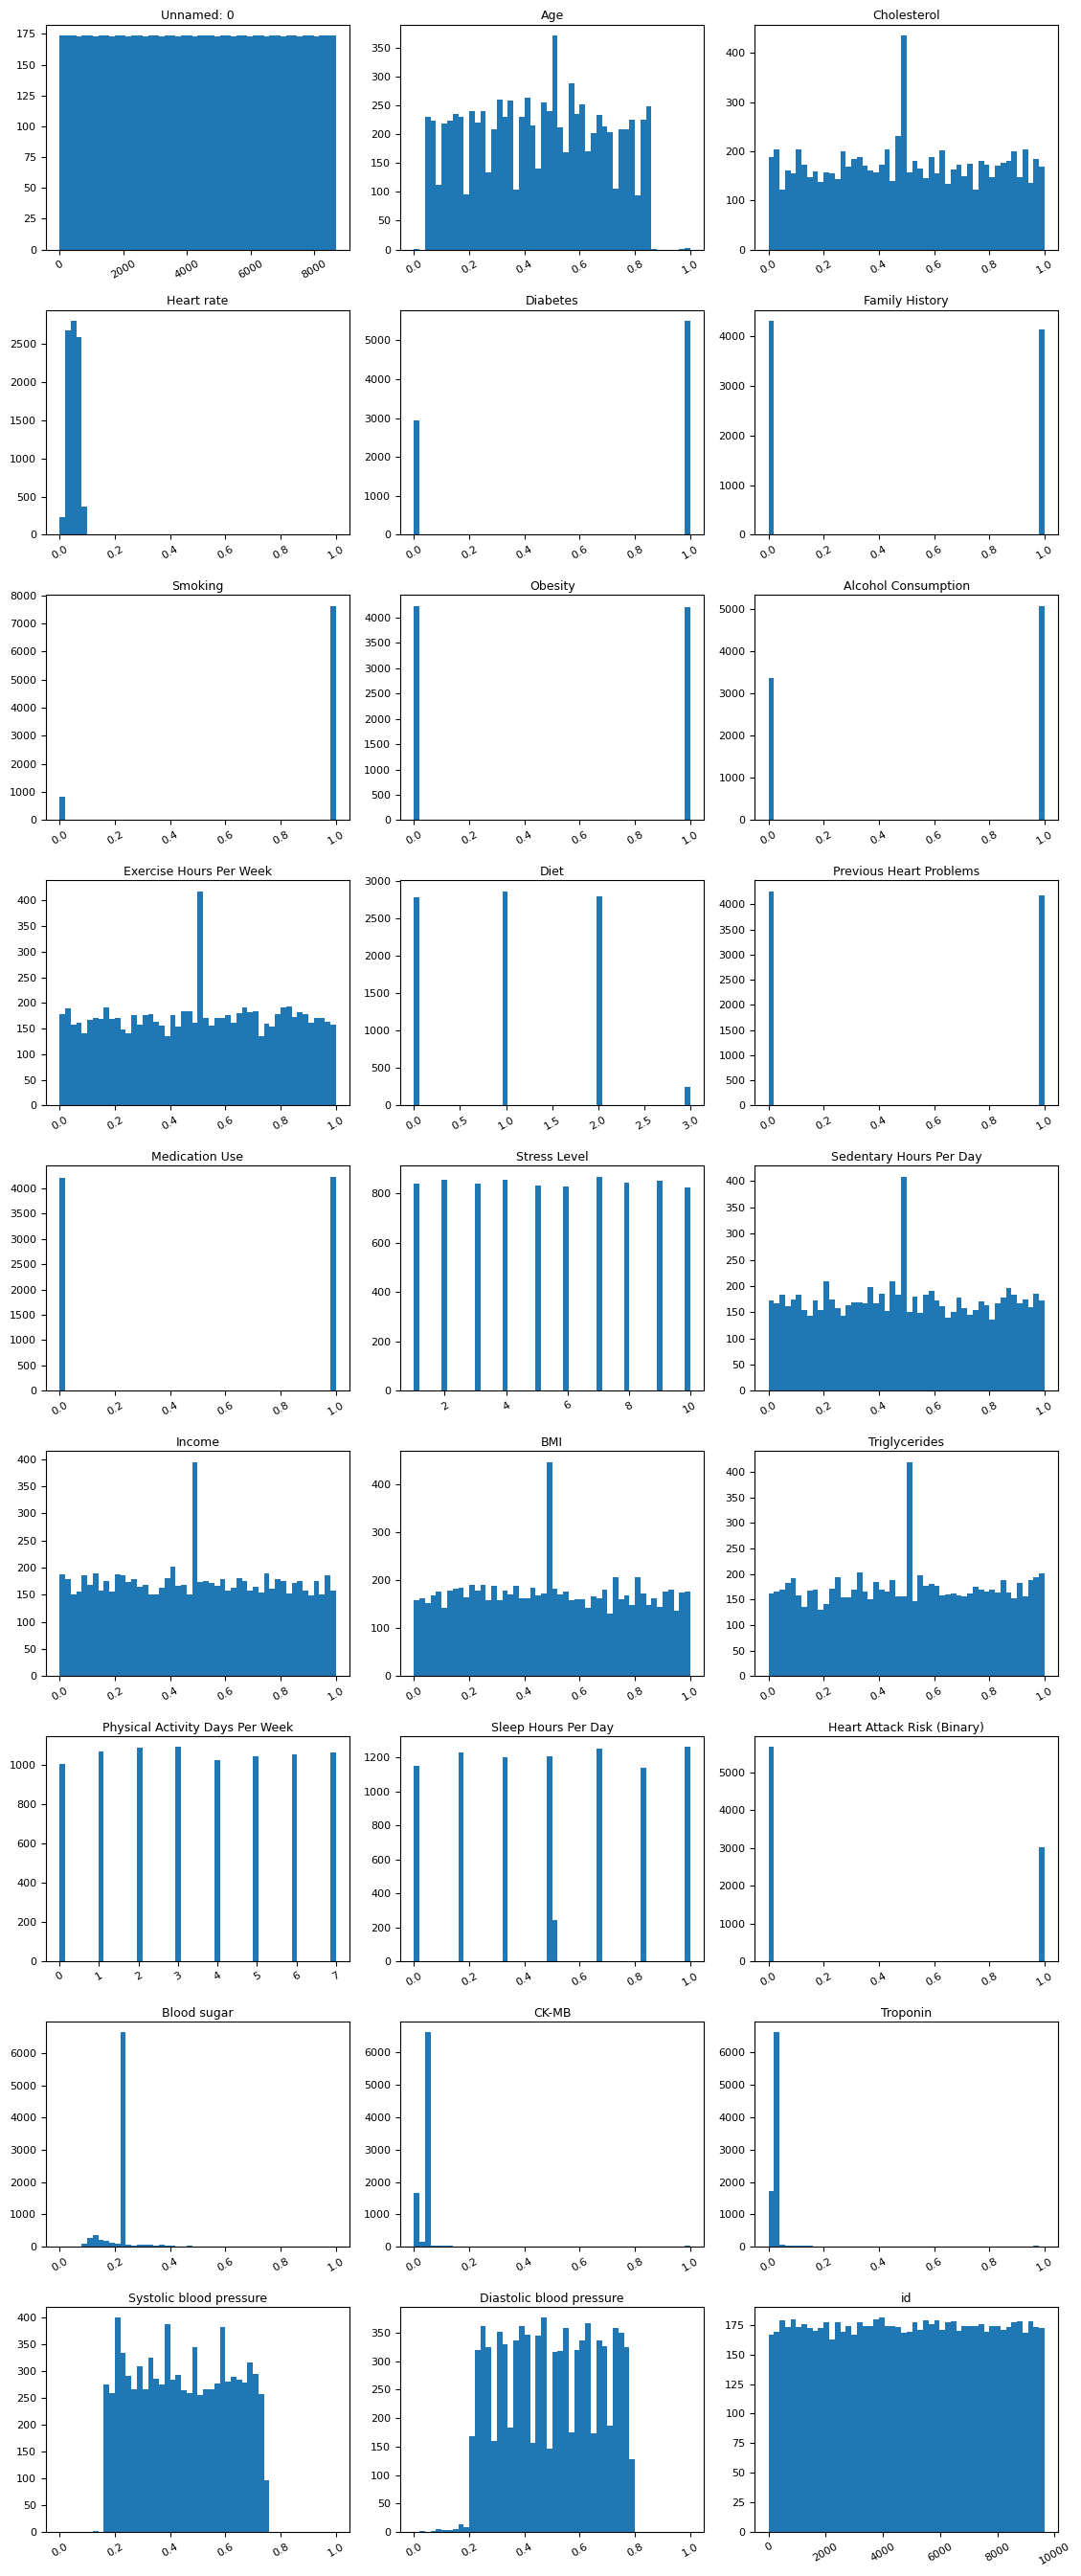


=== BOXPLOTS by target ===


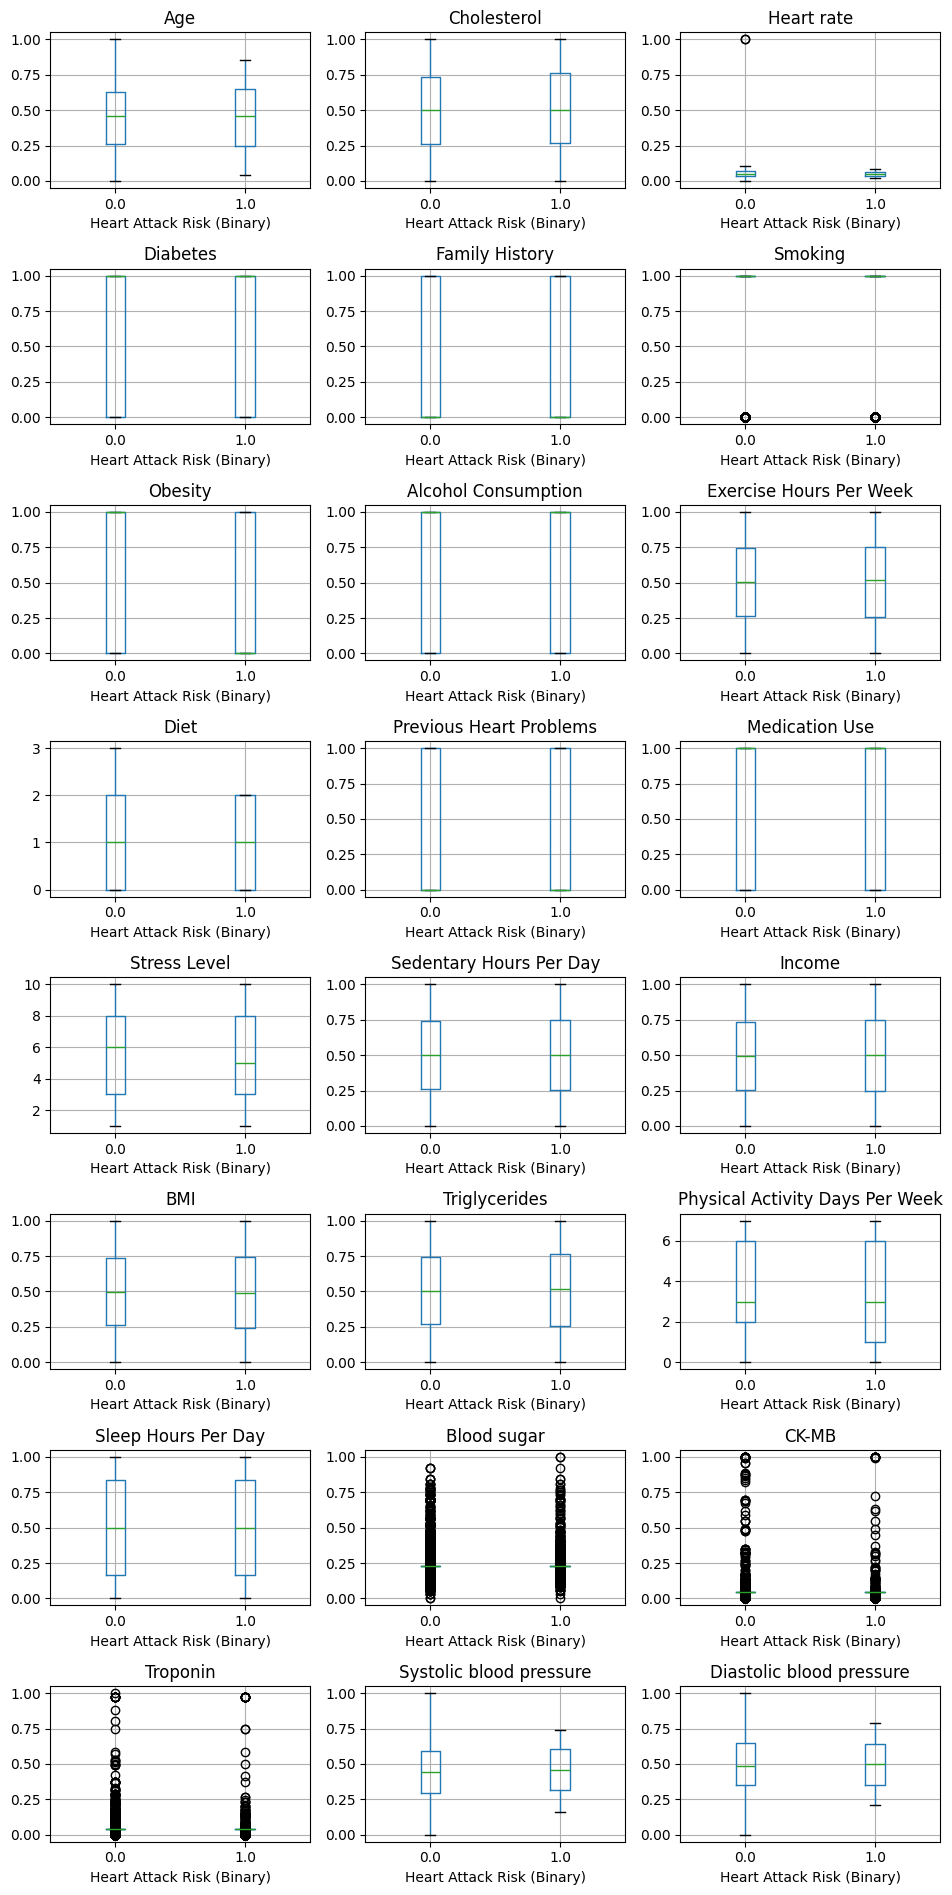

In [3]:
# === Quick overview of train ===
preeda = QuickView(train_df, target="Heart Attack Risk (Binary)").report()



=== QUICK OVERVIEW ===

Appearance (head, T):
                                        0         1         2         3  \
Unnamed: 0                              0         1         2         3   
Age                              0.494382  0.224719  0.629213  0.460674   
Cholesterol                      0.264286  0.953571  0.092857  0.567857   
Heart rate                       0.062328  0.082493  0.064161  0.055912   
Diabetes                              0.0       1.0       0.0       1.0   
Family History                        1.0       0.0       1.0       1.0   
Smoking                               1.0       0.0       1.0       1.0   
Obesity                               1.0       1.0       1.0       1.0   
Alcohol Consumption                   1.0       0.0       0.0       1.0   
Exercise Hours Per Week          0.361618  0.996483  0.995561  0.437277   
Diet                                    2         2         0         0   
Previous Heart Problems               0.0       1.0   

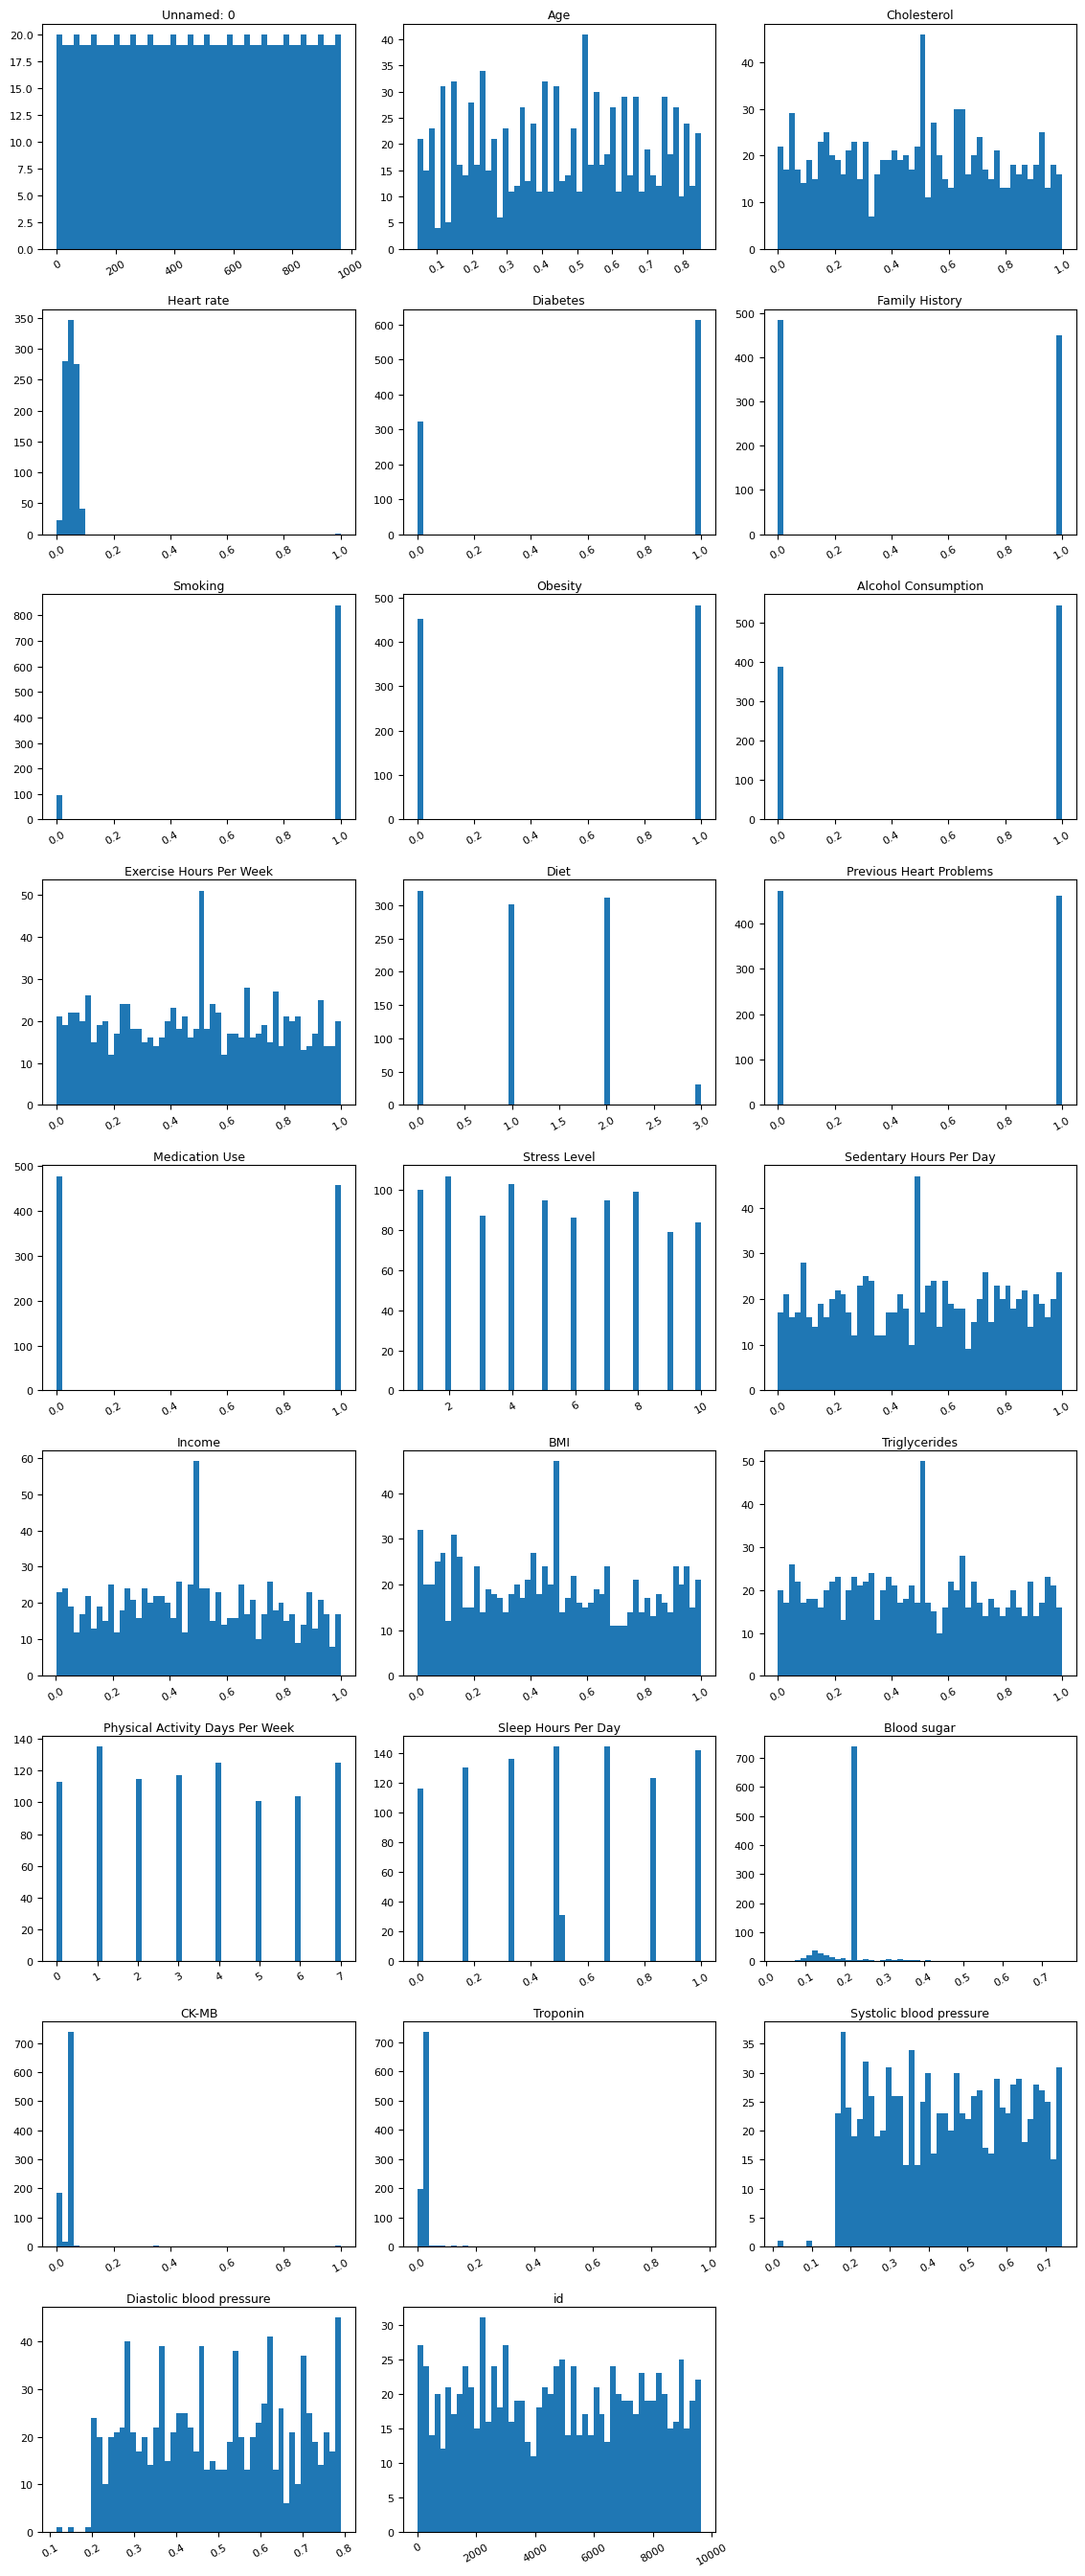


quick_boxplots: specify a valid target (self.target) and ensure it exists in df.


In [4]:
# === Quick overview of test (without target) ===
QuickView(test_df, target="Heart Attack Risk (Binary)").report()


In [5]:
# EDA analysis
eda = EDAAnalyzer(train_df, target_col="Heart Attack Risk (Binary)")
eda.report()


Shape: (8685, 25)
Target balance:
 Heart Attack Risk (Binary)
0.0    0.65308
1.0    0.34692
Name: proportion, dtype: float64
Columns: ['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History', 'Smoking', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk (Binary)', 'Blood sugar', 'CK-MB', 'Troponin', 'Gender', 'Systolic blood pressure', 'Diastolic blood pressure', 'block_missing']
Dtypes:
 Age                                 float64
Cholesterol                         float64
Heart rate                          float64
Diabetes                            float64
Family History                      float64
Smoking                             float64
Alcohol Consumption                 float64
Exercise Hours Per Week             float64
Diet                               catego

In [6]:
eda.df.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,block_missing
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,0.535505,1,1.0,...,3,0.333333,0.0,0.227018,0.048229,0.036512,1,0.212903,0.709302,0
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,1.0,0.068690,2,1.0,...,3,0.833333,0.0,0.150198,0.017616,0.000194,0,0.412903,0.569767,0
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,0.944001,2,1.0,...,2,1.000000,0.0,0.227018,0.048229,0.036512,0,0.238710,0.220930,0
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,1.0,0.697023,0,0.0,...,0,0.333333,1.0,0.227018,0.048229,0.036512,0,0.348387,0.267442,0
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,1.0,0.412878,1,0.0,...,5,1.000000,1.0,0.227018,0.048229,0.036512,1,0.619355,0.441860,0


=== QUICK OVERVIEW ===

Appearance (head, T):
                                        0         1         2         3  \
Age                              0.359551  0.202247  0.606742  0.730337   
Cholesterol                      0.732143     0.325  0.860714  0.007143   
Heart rate                       0.074244  0.047663  0.055912  0.053162   
Diabetes                              1.0       1.0       1.0       0.0   
Family History                        1.0       1.0       0.0       0.0   
Smoking                               1.0       0.0       1.0       1.0   
Alcohol Consumption                   1.0       1.0       1.0       1.0   
Exercise Hours Per Week          0.535505   0.06869  0.944001  0.697023   
Diet                                    1         2         2         0   
Previous Heart Problems               1.0       1.0       1.0       0.0   
Medication Use                        0.0       0.0       1.0       1.0   
Stress Level                            8         9   

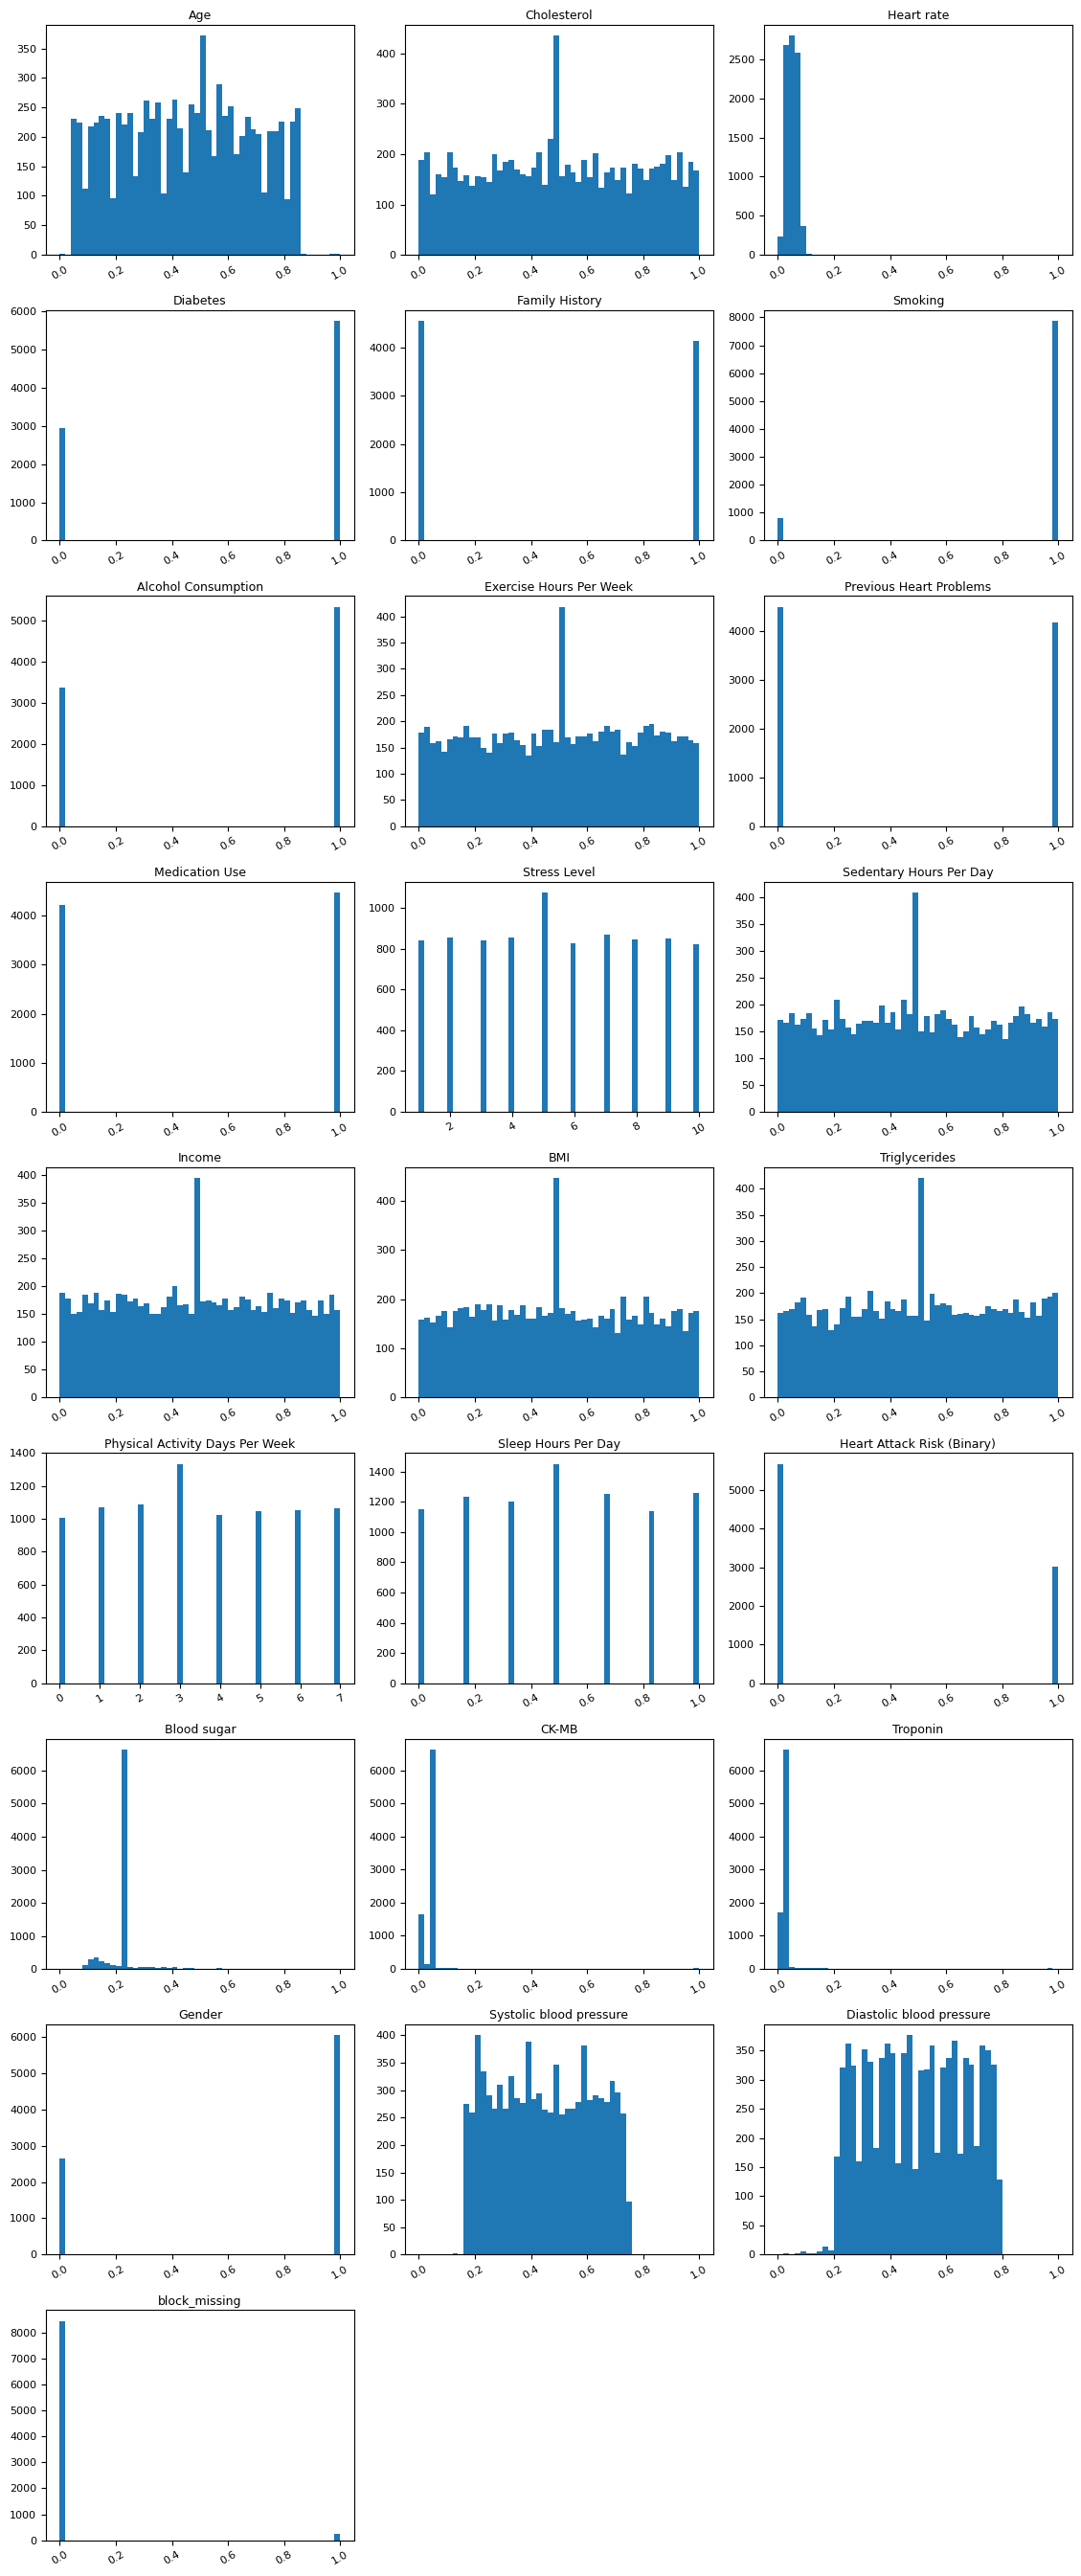


=== BOXPLOTS by target ===


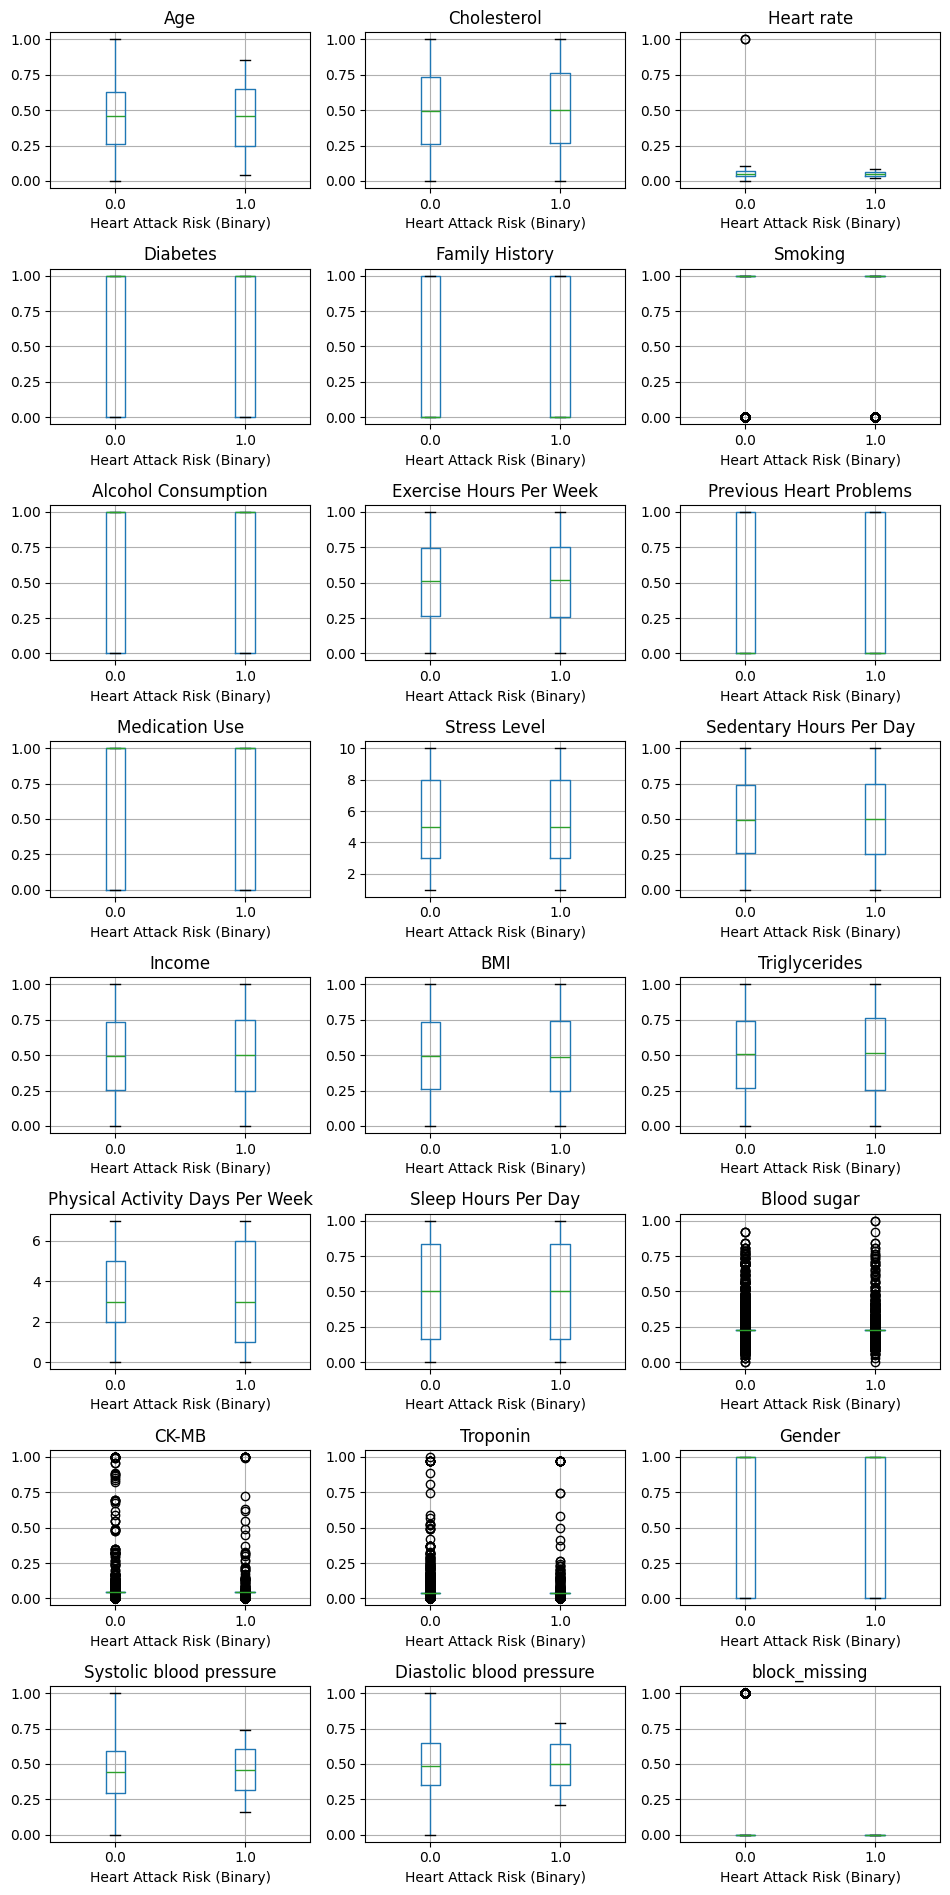

In [7]:
posteda = QuickView(eda.df, target="Heart Attack Risk (Binary)").report()

## Final findings from exploratory data analysis (EDA)

### 1. Train set (training data)
- **Target variable**:
  - `Heart Attack Risk (Binary)` is imbalanced: roughly **65% class 0 (low risk)** and **35% class 1 (high risk)**.
  - This proportion is acceptable but requires careful metric selection. The **Recall/F2** metric may be preferable to Accuracy to avoid missing rare positive cases.

- **Missing values**:
  - Found **243 rows with multiple missing values** (about 3% of the dataset).
  - The gaps are **systemic**: entire blocks of values are missing for groups of patients, indicating data collection specifics rather than random errors.
  - Solution: keep the `block_missing` flag and encode categorical gaps as `Unknown`. This allows the model to use the fact of a "missing block" as a potential risk factor.

- **Feature typing**:
  - Binary features (`Gender`, `Smoking`, `Diabetes`, `Family History`) converted to **boolean**.
  - Categorical features (`Diet`, `Alcohol Consumption`) converted to **categorical** type.
  - Discrete variables (`Stress Level`, `Physical Activity Days Per Week`) converted to **integers**.
  - Continuous features (`Cholesterol`, `BMI`, `Blood Pressure`) left as numeric.

---

### 2. Test set (data for final evaluation)
- **Overall structure**:
  - The distributions of the test data are comparable to the train set, indicating they come from the same population.
  - The balance of key features is preserved; categorical shares and ranges of numerical variables remain within train limits.

- **Missing values**:
  - Systemic gaps are also present in the test set; the structure matches the train data.
  - The `block_missing` flag and encoded categorical `Unknown` values enable processing these cases without losing information.

- **Anomalies and outliers**:
  - Extreme values in the test set fall within train ranges; no new artifacts were found.
  - This reduces the risk that the model encounters unknown patterns.

---

### 3. Overall dataset summary
- After preprocessing, **there are no `NaN` gaps**: they are either replaced with categorical `Unknown` values or moved to a separate flag.
- Class balance is sufficient for proper training but requires metrics that account for Recall.
- Feature typing is strict: boolean, categorical, numerical, and discrete values are converted to the correct format.
- Systemic gaps are captured through the `block_missing` factor, preserving their informativeness instead of discarding data.
- Feature distributions in the test set match those in the train set, ensuring model transferability.
- Bottom line: the data are ready for training, the structure is clean and reproducible, and they reflect both "direct" risk factors (biochemistry, blood pressure) and "indirect" ones (systemic gaps).

✅ Thus, we have a clean and ready dataset in which **all original information is preserved**, including hidden patterns in the missing values. This lays the foundation for building a stable model and sound validation.

---


In [8]:
# ==== 1) Training and model selection ====
# Loading raw data
train_df = pd.read_csv(TRAIN_PATH)

# Train and choose the best model
job = HeartRiskJob(RunCfg())
meta = job.run_and_save(train_df)



### RESULTS (CV, OoF)

,model,key,scenario,F2,F1,ROC_AUC,PR_AUC,Precision,Recall,threshold,TN,FP,FN,TP,N,FP/1000,FN/1000,F2_CI
0,CatBoost,cat,no_leak,0.7353,0.5274,0.5608,0.3988,0.3585,0.9973,0.17,294,5378,8,3005,8685,619.2286,0.9211,"[0.726, 0.744]"
1,CatBoost,cat,with_leak,0.7354,0.5268,0.5560,0.3915,0.3577,0.9990,0.19,268,5404,3,3010,8685,622.2222,0.3454,"[0.726, 0.744]"
2,HistGB,hgb,no_leak,0.7352,0.5264,0.5832,0.4273,0.3573,0.9997,0.04,253,5419,1,3012,8685,623.9493,0.1151,"[0.726, 0.745]"
3,HistGB,hgb,with_leak,0.7353,0.5264,0.5769,0.4220,0.3572,1.0000,0.04,250,5422,0,3013,8685,624.2948,0.0000,"[0.726, 0.745]"
4,RandomForest,rf,no_leak,0.7481,0.5434,0.5894,0.4653,0.3732,0.9990,0.22,616,5056,3,3010,8685,582.1531,0.3454,"[0.740, 0.757]"
5,RandomForest,rf,with_leak,0.7442,0.5393,0.5879,0.4594,0.3697,0.9967,0.23,552,5120,10,3003,8685,589.5222,1.1514,"[0.736, 0.754]"


### Best model

,model,key,scenario,F2,F1,ROC_AUC,PR_AUC,Precision,Recall,threshold*,#features,#cats
0,RandomForest,rf,no_leak,0.7481,0.5434,0.5894,0.4653,0.3732,0.999,0.22,21,1


**Artifacts saved**:

```json
{
  "model_key": "rf",
  "features": [
    "Age",
    "Cholesterol",
    "Heart rate",
    "Diabetes",
    "Family History",
    "Smoking",
    "Alcohol Consumption",
    "Exercise Hours Per Week",
    "Diet",
    "Stress Level",
    "Sedentary Hours Per Day",
    "Income",
    "BMI",
    "Triglycerides",
    "Physical Activity Days Per Week",
    "Sleep Hours Per Day",
    "Blood sugar",
    "Gender",
    "Systolic blood pressure",
    "Diastolic blood pressure",
    "block_missing"
  ],
  "cats": [
    "Diet"
  ],
  "threshold": 0.22,
  "model_path": "best_model.joblib"
}
```

In [9]:
# ==== 2) Load the model ====
inf = HeartRiskInference.from_dir()
print(inf.meta())



{'model_key': 'rf', 'n_features': 21, 'n_cats': 1, 'threshold': 0.22, 'artifacts_dir': 'C:\\DS-Projects\\heart_risk_class\\artifacts'}


In [10]:
# ==== 3) Predict on heart_test.csv ====
df_test = pd.read_csv(Path.cwd().parent / "data" / "heart_test.csv")

# Predictions and distribution
print(inf.predict(df_test).head())
print(inf.class_distribution(df_test))



   proba  prediction
0  0.334           1
1  0.390           1
2  0.316           1
3  0.232           1
4  0.344           1
{1: 879, 0: 87}


In [11]:
# ==== 4) Inference report on heart_test.csv ====
SimpleInferenceSummary().run(inf, test_df)



=== INFERENCE: summary ===
Objects : 966
Threshold: 0.220
Class '1': 879 (90.99%)
Class '0': 87 (9.01%)


{'n': 966,
 'threshold': 0.22,
 'n_pos': 879,
 'n_neg': 87,
 'pos_rate': 0.9099378881987578}

In [12]:
# Web application for heart attack risk screening
nest_asyncio.apply()
uvicorn.run(app, host="127.0.0.1", port=_choose_free_port(8000), reload=False)


INFO:     Started server process [21564]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:58350 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:58350 - "GET /static/style.css?v=6fa40a37 HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [21564]


## Results: inference of the best model and run on the test set

## 1) Deserialization and metadata

- The model was successfully loaded via `HeartRiskInference.from_dir()` based on artifacts in `./artifacts`.
- **Model format:** `joblib` (`best_model.joblib`) — appropriate for sklearn models.
- **Model key:** `rf` (RandomForest), **classification threshold:** `0.22`.
- **Features in the pipeline (21):** clinical and social profile plus the engineered flag `block_missing`.
- **Categoricals:** only `Diet` (handled as a category without leakage).
- Data preparation at inference matches the train flow: `EDAAnalyzer` → alignment by the `features` list → missing columns filled with 0 → prediction.

## 2) Results on `heart_test.csv`

- Total processed: **966 patients**.
- Applied classification threshold **0.22**.
- Final class distribution:
    - **Class 1 ("risk"): 879 (≈91.0%)**
    - **Class 0 ("no risk"): 87 (≈9.0%)**

``` python
{'n': 966,
 'threshold': 0.22,
 'n_pos': 879,
 'n_neg': 87,
 'pos_rate': 0.9099}
```

- Probability (`proba`) distribution on the test set:
    - Mean: **0.34**, median: **0.35**
    - Range: **0.01 -- 0.97**
    - Most predictions lie in **0.25--0.45**
    - There are both **very low (<0.05)** and **very high (>0.9)** confidences.

Thus, the model does not "stick" to a single probability value and clearly differentiates patient subgroups, highlighting both obviously "low-risk" and obviously "high-risk" patients.

## 3) Interpretation and alignment with EDA

- Preprocessing is identical to the train pipeline, including categorical features and missing-value handling.
- Threshold **0.22** was chosen to maximize **F2/Recall**, making the model sensitive to risk (most patients fall into class "1").
- Such a profile is **appropriate for screening tasks**, where minimizing FN is crucial even at the cost of higher FP.

## 4) Web application: status and artifact

- The FastAPI service started successfully; endpoints `GET /`, `POST /predict` and `GET /download` were tested.
- The downloaded CSV `id, prediction`.
- The end user can obtain predictions via the web page or the API.

## 5) Risks and possible improvements

- **Threshold:** the cutoff can be adjusted (0.25--0.3) to balance FP/FN for different scenarios.
- **Probability calibration:** Platt scaling or Isotonic Regression can improve `proba` interpretability.
- **Error analysis:** further study of FP/FN cases may reveal hidden patterns.
- **Stability:** fix library versions and artifacts for reproducibility.

------------------------------------------------------------------------

**Conclusion:**
The best model is `RandomForest` without leakage, with a threshold of **0.22**. It performs inference on the test dataset (966 samples), clearly differentiates patients by probability, and is integrated into the web service. The model is optimized for Recall, matching the screening goals: ready for demonstration and further use.

---


# Overall summary for Project M1: Heart Disease Risk Prediction

## Project goal
Develop a machine learning model and web application to predict heart disease risk in patients based on medical data. The solution should include data exploration (EDA), model training, metric selection, artifact preparation, and creation of a FastAPI service for inference.

## Key steps and results

### 1. Data exploration and preprocessing
- Performed detailed exploratory data analysis (EDA).
- Identified systemic missing values (≈3%), preserved through the binary flag `block_missing`.
- Feature types converted to appropriate formats: boolean, categorical, numerical, discrete.
- Train and test data are comparable in structure and distributions.

**Result:** a clean and reproducible dataset with all information preserved, including systemic gaps.

### 2. Model training and selection
- Compared several models (CatBoost, HistGB, RandomForest).
- Selection metric — **Recall/F2**, priority: do not miss high-risk patients.
- Best model: **RandomForest (rf)** without leakage, with an optimal classification threshold of **0.22**.
- Artifacts saved: `best_model.joblib` and `best_meta.json`.

### 3. Inference on the test set
- Processed **966 patients** from `heart_test.csv`.
- Final class distribution:
  - Class 1 ("risk"): **879 (≈91.0%)**
  - Class 0 ("no risk"): **87 (≈9.0%)**
- Probability distribution `proba`:
  - Mean: 0.34, median: 0.35
  - Range: 0.01 – 0.97
  - Main mass: 0.25–0.45
  - Both very low (<0.05) and very high (>0.9) confidences exist.

**Conclusion:** the model does not "stick" to one probability value and differentiates patient groups by risk.

### 4. Web application (FastAPI)
- Implemented an inference service:
  - web form for CSV upload,
  - JSON endpoints,
  - CSV download button

---

## Summary

- data explored and prepared,
- models trained and compared,
- best model selected and saved (RandomForest, threshold 0.22),
- reproducible ML pipeline implemented,
- FastAPI application developed for inference.
